In [1]:
import os
import gc
import sys
import math
import time
import random
import datetime as dt
import numpy as np
import pandas as pd
import wandb

from glob import glob
from pathlib import Path
from typing import Dict, List, Union
import scipy.signal as scisig
from scipy.signal import butter, lfilter, freqz
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import (
    ReduceLROnPlateau,
    OneCycleLR,
    CosineAnnealingLR,
    CosineAnnealingWarmRestarts,
)
from torch.optim.optimizer import Optimizer
from sklearn.model_selection import GroupKFold,KFold

import warnings
warnings.filterwarnings("ignore")

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Directory settings

In [2]:
OUTPUT_DIR = "./"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Config

In [3]:
class CFG:
    VERSION = '82'

    wandb = False
    debug = True
    create_eegs = False
    apex = True
    visualize = False
    save_all_models = True

    if debug:
        num_workers = 0
        parallel = False
    else:
        num_workers = os.cpu_count()
        parallel = True

    model_name = "resnet1d_gru"
    optimizer = "AdamW"

    factor = 0.9
    eps = 1e-6
    lr = 8e-3
    min_lr = 1e-6

    batch_size = 64
    batch_koef_valid = 2
    batch_scheduler = True
    weight_decay = 1e-2
    gradient_accumulation_steps = 1
    max_grad_norm = 1e7

    fixed_kernel_size = 5
    # N = 9, linear_layer_features = 304
    # N = 7, linear_layer_features = 424
    # N = 5, linear_layer_features = 880
    linear_layer_features = 880   # 1/4, 1/5, 1/6  Signal = 2_000

    kernels = [3, 5, 7, 9, 11]
    # kernels = [5, 7, 9, 11, 13]

    seq_length = 50  # Second's
    sampling_rate = 200  # Hz
    nsamples = seq_length * sampling_rate
    n_split_samples = 5
    out_samples = nsamples // n_split_samples  # 2_000
    sample_delta = nsamples - out_samples  # 8000
    sample_offset = sample_delta // 2
    multi_validation = False

    train_by_stages = False
    train_by_folds = True

    # 'GPD', 'GRDA', 'LPD', 'LRDA', 'Other', 'Seizure'
    n_stages = 2
    train_stages = [0, 1]
    epochs = [50, 100]
    test_total_eval = 4
    total_evals_old = [[(1, 4),(4, 5), (5, 6)], (6, 29)]  # Deprecated
    total_evaluators = [ 
        [   
            {'band':(1, 3), 'excl_evals':[]}, 
            {'band':(4, 4), 'excl_evals':['GPD']}, 
            {'band':(5, 5), 'excl_evals':[]}, 
        ], 
        [   
            {'band':(6, 28), 'excl_evals':[]},
        ], 
    ]             
    
    n_fold = 5
    train_folds = [0, 1, 2, 3, 4]
    # train_folds = [0]

    patience = 11
    seed = 2024

    bandpass_filter = {"low": 0.5, "high": 20, "order": 2}
    rand_filter = {"probab": 0.1, "low": 10, "high": 20, "band": 1.0, "order": 2}
    freq_channels = []  # [(8.0, 12.0)]; [(0.5, 4.5)]
    filter_order = 2

    random_divide_signal = 0.05
    random_close_zone = 0.05
    random_common_negative_signal = 0.0
    random_common_reverse_signal = 0.0
    random_negative_signal = 0.05
    random_reverse_signal = 0.05

    log_step = 100
    log_show = False

    scheduler = "CosineAnnealingWarmRestarts"  # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts','OneCycleLR']

    cosanneal_params = {
        "T_max": 6,
        "eta_min": 1e-5,
        "last_epoch": -1,
    }

    reduce_params = {
        "mode": "min",
        "factor": 0.2,
        "patience": 4,
        "eps": 1e-6,
        "verbose": True,
    }

    cosanneal_res_params = {
        "T_0": 20,
        "eta_min": 1e-6,
        "T_mult": 1,
        "last_epoch": -1,
    }

    target_cols = [
        "seizure_vote",
        "lpd_vote",
        "gpd_vote",
        "lrda_vote",
        "grda_vote",
        "other_vote",
    ]

    pred_cols = [x + "_pred" for x in target_cols]

    map_features = [
        ("Fp1", "T3"),
        ("T3", "O1"),
        ("Fp1", "C3"),
        ("C3", "O1"),
        ("Fp2", "C4"),
        ("C4", "O2"),
        ("Fp2", "T4"),
        ("T4", "O2"),
        #('Fz', 'Cz'), ('Cz', 'Pz'),
    ]

    eeg_features = ["Fp1", "T3", "C3", "O1", "Fp2", "C4", "T4", "O2"]  # 'Fz', 'Cz', 'Pz'
        # 'F3', 'P3', 'F7', 'T5', 'Fz', 'Cz', 'Pz', 'F4', 'P4', 'F8', 'T6', 'EKG']
    feature_to_index = {x: y for x, y in zip(eeg_features, range(len(eeg_features)))}
    simple_features = []  # 'Fz', 'Cz', 'Pz', 'EKG'
    
    n_map_features = len(map_features)
    in_channels = n_map_features + n_map_features * len(freq_channels) + len(simple_features)
    target_size = len(target_cols)

    path_inp = Path(".")
    file_train = path_inp / "updated_train.csv"
    path_train = Path('E:/HMS2024/train_eegs')
    file_features_test = path_train / "100261680.parquet"
#     file_eeg_specs = path_inp / "eeg-spectrogram-by-lead-id-unique/eeg_specs.npy"
    file_raw_eeg = path_inp / "eegs.npy"

# print(CFG.eeg_feat_size, CFG.in_channels)
print(CFG.feature_to_index)
print(CFG.eeg_features)

{'Fp1': 0, 'T3': 1, 'C3': 2, 'O1': 3, 'Fp2': 4, 'C4': 5, 'T4': 6, 'O2': 7}
['Fp1', 'T3', 'C3', 'O1', 'Fp2', 'C4', 'T4', 'O2']


In [4]:
def init_logger(log_file=OUTPUT_DIR + "train.log"):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


LOGGER = init_logger()


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))


def quantize_data(data, classes):
    mu_x = mu_law_encoding(data, classes)
    return mu_x  # quantized


def mu_law_encoding(data, mu):
    mu_x = np.sign(data) * np.log(1 + mu * np.abs(data)) / np.log(mu + 1)
    return mu_x


def mu_law_expansion(data, mu):
    s = np.sign(data) * (np.exp(np.abs(data) * np.log(mu + 1)) - 1) / mu
    return s


def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype="band")


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def butter_lowpass_filter(
    data, cutoff_freq=20, sampling_rate=CFG.sampling_rate, order=4
):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype="low", analog=False)
    filtered_data = lfilter(b, a, data, axis=0)
    return filtered_data


def denoise_filter(x):
    y = butter_bandpass_filter(x, CFG.lowcut, CFG.highcut, CFG.sampling_rate, order=6)
    y = (y + np.roll(y, -1) + np.roll(y, -2) + np.roll(y, -3)) / 4
    y = y[0:-1:4]
    return y

# Parquet to EEG Signals Numpy Processing

In [5]:
def eeg_from_parquet(
    parquet_path: str, display: bool = False, seq_length=CFG.seq_length) -> np.ndarray:
    eeg = pd.read_parquet(parquet_path, columns=CFG.eeg_features)
    rows = len(eeg)

    offset = (rows - CFG.nsamples) // 2

    eeg = eeg.iloc[offset : offset + CFG.nsamples]

    if display:
        plt.figure(figsize=(10, 5))
        offset = 0

    data = np.zeros((CFG.nsamples, len(CFG.eeg_features)))

    for index, feature in enumerate(CFG.eeg_features):
        x = eeg[feature].values.astype("float32") 
        mean = np.nanmean(x)
        nan_percentage = np.isnan(x).mean()
        if nan_percentage < 1: 
            x = np.nan_to_num(x, nan=mean)
        else:  
            x[:] = 0
        data[:, index] = x
        if display:
            if index != 0:
                offset += x.max()
            plt.plot(range(CFG.nsamples), x - offset, label=feature)
            offset -= x.min()

    if display:
        plt.legend()
        name = parquet_path.split("/")[-1].split(".")[0]
        plt.yticks([])
        plt.title(f"EEG {name}", size=16)
        plt.show()

    return data

# Dataset

In [6]:
class EEGDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        batch_size: int,
        eegs: Dict[int, np.ndarray],
        mode: str = "train",
        downsample: int = None,
        bandpass_filter: Dict[str, Union[int, float]] = None,
        rand_filter: Dict[str, Union[int, float]] = None,
    ):
        self.df = df
        self.batch_size = batch_size
        self.mode = mode
        self.eegs = eegs
        self.downsample = downsample
        self.offset = None
        self.bandpass_filter = bandpass_filter
        self.rand_filter = rand_filter
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        X, y_prob = self.__data_generation(index)
        if self.downsample is not None:
            X = X[:: self.downsample, :]
        output = {
            "eeg": torch.tensor(X, dtype=torch.float32),
            "labels": torch.tensor(y_prob, dtype=torch.float32),
        }
        return output

    def set_offset(self, offset: int):
        self.offset = offset

    def __data_generation(self, index):
        X = np.zeros(
            (CFG.out_samples, CFG.in_channels), dtype="float32"
        )  # Size=(10000, 14)

        random_divide_signal = False
        row = self.df.iloc[index]  # Строка Pandas
        data = self.eegs[row.eeg_id]  # Size=(10000, 8)
        if CFG.nsamples != CFG.out_samples:
            if self.mode == "train":
                offset = (CFG.sample_delta * random.randint(0, 1000)) // 1000
            elif not self.offset is None:
                offset = self.offset
            else:
                offset = CFG.sample_offset

            if self.mode == "train" and CFG.random_divide_signal > 0.0 and random.uniform(0.0, 1.0) <= CFG.random_divide_signal:
                random_divide_signal = True
                multipliers = [(1, 2), (2, 3), (3, 4), (3, 5)]
                koef_1, koef_2 = multipliers[random.randint(0, 3)]
                offset = (koef_1 * offset) // koef_2
                data = data[offset:offset+(CFG.out_samples * koef_2) // koef_1,:]
            else:
                data = data[offset:offset+CFG.out_samples,:]

        reverse_signal = False
        negative_signal = False
        if self.mode == "train":
            if CFG.random_common_reverse_signal > 0.0 and random.uniform(0.0, 1.0) <= CFG.random_common_reverse_signal:
                reverse_signal = True
            if CFG.random_common_negative_signal > 0.0 and random.uniform(0.0, 1.0) <= CFG.random_common_negative_signal:
                negative_signal = True

        for i, (feat_a, feat_b) in enumerate(CFG.map_features):
            if self.mode == "train" and CFG.random_close_zone > 0.0 and random.uniform(0.0, 1.0) <= CFG.random_close_zone:
                continue
            
            diff_feat = (
                data[:, CFG.feature_to_index[feat_a]]
                - data[:, CFG.feature_to_index[feat_b]]
            )  # Size=(10000,)

            if self.mode == "train":
                if reverse_signal or CFG.random_reverse_signal > 0.0 and random.uniform(0.0, 1.0) <= CFG.random_reverse_signal:
                    diff_feat = np.flip(diff_feat)
                if negative_signal or CFG.random_negative_signal > 0.0 and random.uniform(0.0, 1.0) <= CFG.random_negative_signal:
                    diff_feat = -diff_feat

            if not self.bandpass_filter is None:
                diff_feat = butter_bandpass_filter(
                    diff_feat,
                    self.bandpass_filter["low"],
                    self.bandpass_filter["high"],
                    CFG.sampling_rate,
                    order=self.bandpass_filter["order"],
                )
            
            if random_divide_signal:
                #diff_feat = cp.asnumpy(cpsig.upfirdn([1.0, 1, 1.0], diff_feat, 2, 3))  # linear interp, rate 2/3
                diff_feat = scisig.upfirdn([1.0, 1, 1.0], diff_feat, koef_1, koef_2)  # linear interp, rate 2/3
                diff_feat = diff_feat[0:CFG.out_samples]

            if (
                self.mode == "train"
                and not self.rand_filter is None
                and random.uniform(0.0, 1.0) <= self.rand_filter["probab"]
            ):
                lowcut = random.randint(
                    self.rand_filter["low"], self.rand_filter["high"]
                )
                highcut = lowcut + self.rand_filter["band"]
                diff_feat = butter_bandpass_filter(
                    diff_feat,
                    lowcut,
                    highcut,
                    CFG.sampling_rate,
                    order=self.rand_filter["order"],
                )

            X[:, i] = diff_feat

        n = CFG.n_map_features
        if len(CFG.freq_channels) > 0:
            for i in range(CFG.n_map_features):
                diff_feat = X[:, i]
                for j, (lowcut, highcut) in enumerate(CFG.freq_channels):
                    band_feat = butter_bandpass_filter(
                        diff_feat, lowcut, highcut, CFG.sampling_rate, order=CFG.filter_order,  # 6
                    )
                    X[:, n] = band_feat
                    n += 1

        for spml_feat in CFG.simple_features:
            feat_val = data[:, CFG.feature_to_index[spml_feat]]
            
            if not self.bandpass_filter is None:
                feat_val = butter_bandpass_filter(
                    feat_val,
                    self.bandpass_filter["low"],
                    self.bandpass_filter["high"],
                    CFG.sampling_rate,
                    order=self.bandpass_filter["order"],
                )

            if (
                self.mode == "train"
                and not self.rand_filter is None
                and random.uniform(0.0, 1.0) <= self.rand_filter["probab"]
            ):
                lowcut = random.randint(
                    self.rand_filter["low"], self.rand_filter["high"]
                )
                highcut = lowcut + self.rand_filter["band"]
                feat_val = butter_bandpass_filter(
                    feat_val,
                    lowcut,
                    highcut,
                    CFG.sampling_rate,
                    order=self.rand_filter["order"],
                )

            X[:, n] = feat_val
            n += 1
            
        X = np.clip(X, -1024, 1024)

        X = np.nan_to_num(X, nan=0) / 32.0

        X = butter_lowpass_filter(X, order=CFG.filter_order)  # 4

        y_prob = np.zeros(CFG.target_size, dtype="float32")  # Size=(6,)
        if self.mode != "test":
            y_prob = row[CFG.target_cols].values.astype(np.float32)

        return X, y_prob

# Helper functions

In [7]:
class KLDivLossWithLogits(nn.KLDivLoss):
    def __init__(self):
        super().__init__(reduction="batchmean")

    def forward(self, y, t):
        y = nn.functional.log_softmax(y, dim=1)
        loss = super().forward(y, t)
        return loss


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def seed_torch(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Model

In [8]:
class ResNet_1D_Block(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding,
        downsampling,
        dilation=1,
        groups=1,
        dropout=0.0,
    ):
        super(ResNet_1D_Block, self).__init__()

        self.bn1 = nn.BatchNorm1d(num_features=in_channels)
        self.relu_1 = nn.Hardswish()
        self.relu_2 = nn.Hardswish()

        self.dropout = nn.Dropout(p=dropout, inplace=False)
        self.conv1 = nn.Conv1d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=False,
        )

        self.bn2 = nn.BatchNorm1d(num_features=out_channels)
        self.conv2 = nn.Conv1d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=False,
        )

        self.maxpool = nn.MaxPool1d(
            kernel_size=2,
            stride=2,
            padding=0,
            dilation=dilation,
        )
        self.downsampling = downsampling

    def forward(self, x):
        identity = x

        out = self.bn1(x)
        out = self.relu_1(out)
        out = self.dropout(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu_2(out)
        out = self.dropout(out)
        out = self.conv2(out)

        out = self.maxpool(out)
        identity = self.downsampling(x)

        out += identity
        return out


class EEGNet(nn.Module):
    def __init__(
        self,
        kernels,
        in_channels,
        fixed_kernel_size,
        num_classes,
        linear_layer_features,
        dilation=1,
        groups=1,
    ):
        super(EEGNet, self).__init__()
        self.kernels = kernels
        self.planes = 24
        self.parallel_conv = nn.ModuleList()
        self.in_channels = in_channels

        for i, kernel_size in enumerate(list(self.kernels)):
            sep_conv = nn.Conv1d(
                in_channels=in_channels,
                out_channels=self.planes,
                kernel_size=(kernel_size),
                stride=1,
                padding=0,
                dilation=dilation,
                groups=groups,
                bias=False,
            )
            self.parallel_conv.append(sep_conv)

        self.bn1 = nn.BatchNorm1d(num_features=self.planes)
        self.relu_1 = nn.SiLU()
        self.relu_2 = nn.SiLU()

        self.conv1 = nn.Conv1d(
            in_channels=self.planes,
            out_channels=self.planes,
            kernel_size=fixed_kernel_size,
            stride=2,
            padding=2,
            dilation=dilation,
            groups=groups,
            bias=False,
        )

        self.block = self._make_resnet_layer(
            kernel_size=fixed_kernel_size,
            stride=1,
            dilation=dilation,
            groups=groups,
            padding=fixed_kernel_size // 2,
        )
        self.bn2 = nn.BatchNorm1d(num_features=self.planes)
        self.avgpool = nn.AvgPool1d(kernel_size=6, stride=6, padding=2)

        self.rnn = nn.GRU(
            input_size=self.in_channels,
            hidden_size=128,
            num_layers=1,
            bidirectional=True,
            # dropout=0.2,
        )

        self.fc = nn.Linear(in_features=linear_layer_features, out_features=num_classes)

    def _make_resnet_layer(
        self,
        kernel_size,
        stride,
        dilation=1,
        groups=1,
        blocks=5,
        padding=0,
        dropout=0.0,
    ):
        layers = []

        for i in range(blocks):
            downsampling = nn.Sequential(
                nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
            )
            layers.append(
                ResNet_1D_Block(
                    in_channels=self.planes,
                    out_channels=self.planes,
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=padding,
                    downsampling=downsampling,
                    dilation=dilation,
                    groups=groups,
                    dropout=dropout,
                )
            )
        return nn.Sequential(*layers)

    def extract_features(self, x):
        x = x.permute(0, 2, 1)

        out_sep = []
        for i in range(len(self.kernels)):
            sep = self.parallel_conv[i](x)
            out_sep.append(sep)

        out = torch.cat(out_sep, dim=2)
        out = self.bn1(out)
        out = self.relu_1(out)
        out = self.conv1(out)

        out = self.block(out)
        out = self.bn2(out)
        out = self.relu_2(out)
        out = self.avgpool(out)

        out = out.reshape(out.shape[0], -1)
        rnn_out, _ = self.rnn(x.permute(0, 2, 1))
        new_rnn_h = rnn_out[:, -1, :]

        new_out = torch.cat([out, new_rnn_h], dim=1)
        return new_out

    def forward(self, x):
        new_out = self.extract_features(x)
        result = self.fc(new_out)
        return result

# Adan Optimizer

In [9]:
class Adan(Optimizer):
    def __init__(
        self,
        params,
        lr=1e-3,
        betas=(0.98, 0.92, 0.99),
        eps=1e-8,
        weight_decay=0.2,
        max_grad_norm=0.0,
        no_prox=False,
    ):
        if not 0.0 <= max_grad_norm:
            raise ValueError("Invalid Max grad norm: {}".format(max_grad_norm))
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= betas[2] < 1.0:
            raise ValueError("Invalid beta parameter at index 2: {}".format(betas[2]))
        defaults = dict(
            lr=lr,
            betas=betas,
            eps=eps,
            weight_decay=weight_decay,
            max_grad_norm=max_grad_norm,
            no_prox=no_prox,
        )
        super(Adan, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Adan, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault("no_prox", False)

    @torch.no_grad()
    def restart_opt(self):
        for group in self.param_groups:
            group["step"] = 0
            for p in group["params"]:
                if p.requires_grad:
                    state = self.state[p]
                    # State initialization

                    # Exponential moving average of gradient values
                    state["exp_avg"] = torch.zeros_like(p)
                    # Exponential moving average of squared gradient values
                    state["exp_avg_sq"] = torch.zeros_like(p)
                    # Exponential moving average of gradient difference
                    state["exp_avg_diff"] = torch.zeros_like(p)

    @torch.no_grad()
    def step(self):
        """
        Performs a single optimization step.
        """
        if self.defaults["max_grad_norm"] > 0:
            device = self.param_groups[0]["params"][0].device
            global_grad_norm = torch.zeros(1, device=device)

            max_grad_norm = torch.tensor(self.defaults["max_grad_norm"], device=device)
            for group in self.param_groups:

                for p in group["params"]:
                    if p.grad is not None:
                        grad = p.grad
                        global_grad_norm.add_(grad.pow(2).sum())

            global_grad_norm = torch.sqrt(global_grad_norm)

            clip_global_grad_norm = torch.clamp(
                max_grad_norm / (global_grad_norm + group["eps"]), max=1.0
            )
        else:
            clip_global_grad_norm = 1.0

        for group in self.param_groups:
            beta1, beta2, beta3 = group["betas"]
            # assume same step across group now to simplify things
            # per parameter step can be easily support by making it tensor, or pass list into kernel
            if "step" in group:
                group["step"] += 1
            else:
                group["step"] = 1

            bias_correction1 = 1.0 - beta1 ** group["step"]
            bias_correction2 = 1.0 - beta2 ** group["step"]
            bias_correction3 = 1.0 - beta3 ** group["step"]

            for p in group["params"]:
                if p.grad is None:
                    continue

                state = self.state[p]
                if len(state) == 0:
                    state["exp_avg"] = torch.zeros_like(p)
                    state["exp_avg_sq"] = torch.zeros_like(p)
                    state["exp_avg_diff"] = torch.zeros_like(p)

                grad = p.grad.mul_(clip_global_grad_norm)
                if "pre_grad" not in state or group["step"] == 1:
                    state["pre_grad"] = grad

                copy_grad = grad.clone()

                exp_avg, exp_avg_sq, exp_avg_diff = (
                    state["exp_avg"],
                    state["exp_avg_sq"],
                    state["exp_avg_diff"],
                )
                diff = grad - state["pre_grad"]

                update = grad + beta2 * diff
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)  # m_t
                exp_avg_diff.mul_(beta2).add_(diff, alpha=1 - beta2)  # diff_t
                exp_avg_sq.mul_(beta3).addcmul_(update, update, value=1 - beta3)  # n_t

                denom = ((exp_avg_sq).sqrt() / math.sqrt(bias_correction3)).add_(
                    group["eps"]
                )
                update = (
                    (
                        exp_avg / bias_correction1
                        + beta2 * exp_avg_diff / bias_correction2
                    )
                ).div_(denom)

                if group["no_prox"]:
                    p.data.mul_(1 - group["lr"] * group["weight_decay"])
                    p.add_(update, alpha=-group["lr"])
                else:
                    p.add_(update, alpha=-group["lr"])
                    p.data.div_(1 + group["lr"] * group["weight_decay"])

                state["pre_grad"] = copy_grad

In [28]:
model = EEGNet(
        kernels=CFG.kernels,
        in_channels=CFG.in_channels,
        fixed_kernel_size=CFG.fixed_kernel_size,
        num_classes=CFG.target_size,
        linear_layer_features=CFG.linear_layer_features,
    )
num_parameters = sum(p.numel() for p in model.parameters())
num_parameters

150246

# Train func

In [10]:
def train_fn(
    stage, fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()

    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0

    for step, batch in enumerate(train_loader):
        eegs = batch["eeg"].to(device)
        labels = batch["labels"].to(device)
        batch_size = labels.size(0)

        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(eegs)
            loss = criterion(F.log_softmax(y_preds, dim=1), labels)

        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps

        losses.update(loss.item(), batch_size)

        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm
        )

        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()

        if CFG.log_show and (
            step % CFG.log_step == 0 or step == (len(train_loader) - 1)
        ):
            # remain=timeSince(start, float(step + 1) / len(train_loader))
            LOGGER.info(
                f"Epoch {epoch+1} [{step}/{len(train_loader)}] Loss: {losses.val:.4f} Loss Avg:{losses.avg:.4f}"
            )
            # "Elapsed {remain:s} Grad: {grad_norm:.4f}  LR: {cheduler.get_lr()[0]:.8f}"

        if CFG.wandb:
            wandb.log(
                {
                    f"[fold{fold}] loss": losses.val,
                    f"[fold{fold}] lr": scheduler.get_lr()[0],
                }
            )
    return losses.avg

# Valid Func

In [11]:
def valid_fn(stage, epoch, valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    targets = []
    start = end = time.time()

    for step, batch in enumerate(valid_loader):
        eegs = batch["eeg"].to(device)
        labels = batch["labels"].to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(eegs)
            loss = criterion(F.log_softmax(y_preds, dim=1), labels)

        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps

        losses.update(loss.item(), batch_size)
        preds.append(nn.Softmax(dim=1)(y_preds).to("cpu").numpy())
        targets.append(labels.to("cpu").numpy())
        end = time.time()

        if CFG.log_show and (
            step % CFG.log_step == 0 or step == (len(valid_loader) - 1)
        ):
            # remain=timeSince(start, float(step + 1) / len(valid_loader))
            LOGGER.info(
                f"Epoch {epoch+1} VALIDATION: [{step}/{len(valid_loader)}] Val Loss: {losses.val:.4f} Val Loss Avg: {losses.avg:.4f}"
            )
            # Elapsed {remain:s}

    predictions = np.concatenate(preds)
    targets = np.concatenate(targets)

    return losses.avg, predictions

# Build Optimizer

In [12]:
def build_optimizer(cfg, model, device, epochs, num_batches_per_epoch):
    lr = cfg.lr
    # lr = default_configs["lr"]
    if cfg.optimizer == "SAM":
        base_optimizer = (
            torch.optim.SGD
        )  # define an optimizer for the "sharpness-aware" update
        optimizer_model = SAM(
            model.parameters(),
            base_optimizer,
            lr=lr,
            momentum=0.9,
            weight_decay=cfg.weight_decay,
            adaptive=True,
        )
    elif cfg.optimizer == "Ranger21":
        optimizer_model = Ranger21(
            model.parameters(),
            lr=lr,
            weight_decay=cfg.weight_decay,
            num_epochs=epochs,
            num_batches_per_epoch=num_batches_per_epoch,
        )
    elif cfg.optimizer == "SGD":
        optimizer_model = torch.optim.SGD(
            model.parameters(), lr=lr, weight_decay=cfg.weight_decay, momentum=0.9
        )
    elif cfg.optimizer == "Adam":
        optimizer_model = Adam(model.parameters(), lr=lr, weight_decay=CFG.weight_decay)
    elif cfg.optimizer == "AdamW":
        optimizer_model = AdamW(
            model.parameters(), lr=lr, weight_decay=CFG.weight_decay
        )
    elif cfg.optimizer == "Lion":
        optimizer_model = Lion(model.parameters(), lr=lr, weight_decay=cfg.weight_decay)
    elif cfg.optimizer == "Adan":
        optimizer_model = Adan(model.parameters(), lr=lr, weight_decay=cfg.weight_decay)

    return optimizer_model

# Scheduler

In [13]:
def get_scheduler(optimizer, epochs, steps_per_epoch):
    if CFG.scheduler == "ReduceLROnPlateau":
        scheduler = ReduceLROnPlateau(optimizer, **CFG.reduce_params)
    elif CFG.scheduler == "CosineAnnealingLR":
        scheduler = CosineAnnealingLR(optimizer, **CFG.cosanneal_params)
    elif CFG.scheduler == "CosineAnnealingWarmRestarts":
        scheduler = CosineAnnealingWarmRestarts(optimizer, **CFG.cosanneal_res_params)
    elif CFG.scheduler == "OneCycleLR":
        scheduler = OneCycleLR(
            optimizer=optimizer,
            epochs=epochs,
            pct_start=0.0,
            steps_per_epoch=steps_per_epoch,
            max_lr=CFG.lr,
            div_factor=25,
            final_div_factor=4.0e-01,
        )
    return scheduler

# Train Loop

In [14]:
def train_loop(stage, epochs, folds, fold, directory, prev_dir, eggs):
    train_folds = folds[folds["fold"] != fold].reset_index(drop=True)
    valid_folds = folds[folds["fold"] == fold].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_cols].values

    train_dataset = EEGDataset(
        train_folds,
        batch_size=CFG.batch_size,
        mode="train",
        eegs=eggs,
        bandpass_filter=CFG.bandpass_filter,
        rand_filter=CFG.rand_filter,
    )
        
    valid_dataset = EEGDataset(
        valid_folds,
        batch_size=CFG.batch_size,
        mode="valid",
        eegs=eggs,
        bandpass_filter=CFG.bandpass_filter,
        #rand_filter=CFG.rand_filter,
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=True,
    )

    valid_loader = DataLoader(
        valid_dataset,
        batch_size=CFG.batch_size * CFG.batch_koef_valid,
        shuffle=False,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=False,
    )

    LOGGER.info(
        f"========== stage: {stage} fold: {fold} training {len(train_loader)} / {len(valid_loader)} =========="
    )

    model = EEGNet(
        kernels=CFG.kernels,
        in_channels=CFG.in_channels,
        fixed_kernel_size=CFG.fixed_kernel_size,
        num_classes=CFG.target_size,
        linear_layer_features=CFG.linear_layer_features,
    )

    if stage > 1:
        model_weight = f"{prev_dir}{CFG.model_name}_ver-{CFG.VERSION}_stage-{stage-1}_fold-{fold}_best.pth"
        checkpoint = torch.load(model_weight, map_location=device)
        model.load_state_dict(checkpoint["model"])

    model.to(device)

    # CPMP: wrap the model to use all GPUs
    if CFG.parallel:
        model = nn.DataParallel(model)

    optimizer = build_optimizer(
        CFG, model, device, epochs=epochs, num_batches_per_epoch=len(train_loader)
    )
    scheduler = get_scheduler(
        optimizer, epochs=epochs, steps_per_epoch=len(train_loader)
    )
    criterion = nn.KLDivLoss(reduction="batchmean")

    best_score = np.inf
    for epoch in range(epochs):
        start_time = time.time()

        # train
        avg_loss = train_fn(
            stage,
            fold,
            train_loader,
            model,
            criterion,
            optimizer,
            epoch,
            scheduler,
            device,
        )

        # eval
        valid_dataset.set_offset(CFG.sample_offset)
        avg_val_loss, predictions = valid_fn(
            stage,
            epoch,
            valid_loader,
            model,
            criterion,
            device,
        )
        
        avg_loss_line = ''
        if CFG.multi_validation:
            multi_avg_val_loss = np.zeros(CFG.n_split_samples)
            start = (2 * CFG.sample_delta) // CFG.n_split_samples
            finish = (3 * CFG.sample_delta) // CFG.n_split_samples
            delta = (finish - start) // 5
            for i in range(CFG.n_split_samples):
                valid_dataset.set_offset(start)
                multi_avg_val_loss[i], _ = valid_fn(
                    stage,
                    epoch,
                    valid_loader,
                    model,
                    criterion,
                    device,
                )
                avg_loss_line += f" {multi_avg_val_loss[i]:.4f}"
                start += delta
            avg_loss_line += f" mean={np.mean(multi_avg_val_loss):.4f}"

        elapsed = time.time() - start_time

        LOGGER.info(
            f"Epoch {epoch+1} Avg Train Loss: {avg_loss:.4f} Avg Valid Loss: {avg_val_loss:.4f} / {avg_loss_line}"
        )
        #   time: {elapsed:.0f}s
        if CFG.wandb:
            wandb.log(
                {
                    f"[fold{fold}] stage": stage,
                    f"[fold{fold}] epoch": epoch + 1,
                    f"[fold{fold}] avg_train_loss": avg_loss,
                    f"[fold{fold}] avg_val_loss": avg_val_loss,
                    #f"[fold{fold}] score": score,
                }
            )

        if CFG.save_all_models:
            torch.save(
                {"model": model.state_dict(), "predictions": predictions},
                f"{directory}{CFG.model_name}_ver-{CFG.VERSION}_stage-{stage}_fold-{fold}_epoch-{epoch}_val-{avg_val_loss:.4f}_train-{avg_loss:.4f}.pth",
            )

        if best_score > avg_val_loss:
            best_score = avg_val_loss
            LOGGER.info(f"Epoch {epoch+1} Save Best Valid Loss: {avg_val_loss:.4f}")
            # CPMP: save the original model. It is stored as the module attribute of the DP model.
            torch.save(
                {"model": model.state_dict(), "predictions": predictions},
                f"{directory}{CFG.model_name}_ver-{CFG.VERSION}_stage-{stage}_fold-{fold}_best.pth",
            )

    predictions = torch.load(
        f"{directory}{CFG.model_name}_ver-{CFG.VERSION}_stage-{stage}_fold-{fold}_best.pth",
        map_location=torch.device("cpu"),
    )["predictions"]

    # valid_folds[[f"pred_{c}" for c in CFG.target_cols]] = predictions
    valid_folds[CFG.pred_cols] = predictions
    valid_folds[CFG.target_cols] = valid_labels

    torch.cuda.empty_cache()
    gc.collect()

    return valid_folds, best_score

# Load train data

In [15]:
train = pd.read_csv(CFG.file_train)
TARGETS = train.columns[-6:]
print("Train shape:", train.shape)
print("Targets", list(TARGETS))

train["total_evaluators"] = train[CFG.target_cols].sum(axis=1)

train_uniq = train.drop_duplicates(subset=["eeg_id"] + list(TARGETS))

print(f"There are {train.patient_id.nunique()} patients in the training data.")
print(f"There are {train.eeg_id.nunique()} EEG IDs in the training data.")
print(f"There are {train_uniq.shape[0]} unique eeg_id + votes in the training data.")

if CFG.visualize:
    train_uniq.eeg_id.value_counts().value_counts().plot(
        kind="bar",
        title=f"Distribution of Count of EEG w Unique Vote: "
        f"{train_uniq.shape[0]} examples",
    )

del train_uniq
_ = gc.collect()

Train shape: (100784, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
There are 1921 patients in the training data.
There are 16064 EEG IDs in the training data.
There are 18996 unique eeg_id + votes in the training data.


In [16]:
if CFG.visualize:
    plt.figure(figsize=(10, 6))
    plt.hist(train["total_evaluators"], bins=10, color="blue", edgecolor="black")
    plt.title("Histogram of Total Evaluators")
    plt.xlabel("Total Evaluators")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

tst_eeg_df = pd.read_parquet(CFG.file_features_test)
tst_eeg_features = tst_eeg_df.columns
print(f"There are {len(tst_eeg_features)} raw eeg features")
print(list(tst_eeg_features))
del tst_eeg_df
_ = gc.collect()

There are 20 raw eeg features
['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']


# Split Data

In [17]:
uselabel = train.drop_duplicates(subset = ['eeg_id']).label_id.tolist()
uselabel

[127492639,
 1978807404,
 557980729,
 4099147263,
 1963161945,
 3631726128,
 4265493714,
 3051612434,
 3774460362,
 2678832786,
 2922645408,
 212995060,
 2581514982,
 92643023,
 116172961,
 643458890,
 2564153803,
 239963779,
 1605170669,
 474823595,
 3042959589,
 1672004489,
 3001079370,
 1554550678,
 3616273655,
 2692343476,
 164296540,
 4133262183,
 1900116647,
 1418039992,
 3424058528,
 3368113098,
 2825559136,
 2660894080,
 2768248759,
 4044160416,
 1456770042,
 2214815956,
 1832101066,
 2192283673,
 1622817309,
 462363590,
 4233854567,
 1575215077,
 3782281219,
 4226410738,
 807031283,
 2944613501,
 2100670995,
 2402782492,
 361209024,
 513641250,
 4117135159,
 135897239,
 4193531390,
 2075631178,
 2458607184,
 245081975,
 1827123696,
 3074802187,
 814868672,
 1158561579,
 3191986017,
 814407858,
 3587168508,
 2926135348,
 2971910547,
 1943001855,
 914021164,
 296816339,
 3812258567,
 4070077333,
 213732050,
 772789399,
 790125239,
 3974368366,
 1153628412,
 3488615355,
 42798546

In [18]:
train = train[train["label_id"].isin(uselabel)].copy()
print(train.shape[0])

y_data = train[TARGETS].values + 0  # Regularization value
y_data = y_data / y_data.sum(axis=1, keepdims=True)
train[TARGETS] = y_data

train["target"] = train["expert_consensus"]

train[train['total_evaluators'] == CFG.test_total_eval].groupby(['expert_consensus','total_evaluators']).count()

16064


,,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
expert_consensus,total_evaluators,,,,,,,,,,,,,,,
GPD,4,59,59,59,59,59,59,59,59,59,59,59,59,59,59,59
GRDA,4,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
LPD,4,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133
LRDA,4,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14
Other,4,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86
Seizure,4,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66


In [19]:
if CFG.test_total_eval > 0:
    train['key_id'] = range(train.shape[0])

    train_pop_olds = []
    for total_eval in CFG.total_evals_old:
        if type(total_eval) is list:
            pop_idx = (train["total_evaluators"] >= total_eval[0][0]) & (
                train["total_evaluators"] < total_eval[0][1]
            ) | (train["total_evaluators"] >= total_eval[1][0]) & (
                train["total_evaluators"] < total_eval[1][1]
            )
        else:
            pop_idx = (train["total_evaluators"] >= total_eval[0]) & (
                train["total_evaluators"] < total_eval[1]
            )

        train_pop = train[pop_idx].copy().reset_index()

        sgkf = KFold(n_splits=CFG.n_fold)
        train_pop["fold"] = -1
        for fold_id, (_, val_idx) in enumerate(
            sgkf.split(train_pop)
        ):
            train_pop.loc[val_idx, "fold"] = fold_id
        train_pop_olds.append(train_pop)
        print(train_pop.shape[0])

10390
5233


In [20]:
train_pops = []
for eval_list in CFG.total_evaluators:
    result=[]
    train_pop = train  
    for eval_dict in eval_list:
        band = eval_dict['band']
        pop_idx = (train_pop["total_evaluators"] >= band[0]) 
        pop_idx &= (train_pop["total_evaluators"] <= band[1])
        for exclude in eval_dict['excl_evals']:
            pop_idx &= ~(train_pop['expert_consensus'] == exclude)
            pass
        result.append(train_pop[pop_idx])
    train_pop = pd.concat(result).copy().reset_index()

    sgkf = GroupKFold(n_splits=CFG.n_fold)
    train_pop["fold"] = -1
    for fold_id, (_, val_idx) in enumerate(
        sgkf.split(train_pop, y=train_pop["target"], groups=train_pop["patient_id"])
    ):
        train_pop.loc[val_idx, "fold"] = fold_id

    train_pops.append(train_pop)
    print(train_pop.shape[0])

train_0 = train_pops[0]
train_0[train_0['total_evaluators'] == CFG.test_total_eval].groupby(['expert_consensus','total_evaluators']).count()

10772
5233


,,index,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target,key_id,fold
expert_consensus,total_evaluators,,,,,,,,,,,,,,,,,,
GRDA,4,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
LPD,4,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133,133
LRDA,4,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14
Other,4,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86,86
Seizure,4,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66,66


In [21]:
if CFG.test_total_eval > 0:
    df_old = train_pop_olds[0].copy(deep=True).set_index(['key_id'], drop=True).drop(columns=['fold'])
    df_new = train_pops[0].copy(deep=True).set_index(['key_id'], drop=True).drop(columns=['fold'])

    #outer merge the two DataFrames, adding an indicator column called 'Exist'
    diff_df = pd.merge(df_old, df_new, how='outer', indicator='Exist')

    #find which rows don't exist in both DataFrames
    diff_df = diff_df.loc[diff_df['Exist'] != 'both']
    display(diff_df)

    del df_old, df_new, diff_df, train_pop_olds
    _ = gc.collect()

,index,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,total_evaluators,target,Exist
3,30,1626798710,0,0.0,1219001,2,74.0,3631726128,23435,Seizure,0.6,0.0,0.4,0.0,0.0,0.0,5,Seizure,right_only
4,32,2529955608,0,0.0,1219001,4,190.0,4265493714,23435,Seizure,0.6,0.0,0.4,0.0,0.0,0.0,5,Seizure,right_only
11,62,989810287,0,0.0,2843061,0,0.0,116172961,13521,Other,0.0,0.2,0.0,0.0,0.0,0.8,5,Other,right_only
31,172,4000022002,0,0.0,7122706,0,0.0,462363590,11471,Seizure,0.6,0.0,0.0,0.0,0.0,0.4,5,Seizure,right_only
60,458,3636015289,0,0.0,12849827,30,452.0,640352706,34998,GPD,0.0,0.0,0.8,0.0,0.0,0.2,5,GPD,right_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10719,99802,3453816311,0,0.0,2122259534,2,536.0,128199276,48272,GPD,0.0,0.0,1.0,0.0,0.0,0.0,5,GPD,right_only
10744,99964,1573558442,0,0.0,2126560277,15,704.0,1311940936,22597,Seizure,0.6,0.0,0.0,0.0,0.0,0.4,5,Seizure,right_only
10783,100317,2024173188,0,0.0,2136113568,0,0.0,1857591903,51025,Seizure,0.6,0.0,0.0,0.2,0.0,0.2,5,Seizure,right_only
10815,100616,4288875638,0,0.0,2145358771,0,0.0,3377992611,200,Seizure,0.8,0.2,0.0,0.0,0.0,0.0,5,Seizure,right_only


Pop 1: train unique eeg_id + votes shape: (10772, 20)


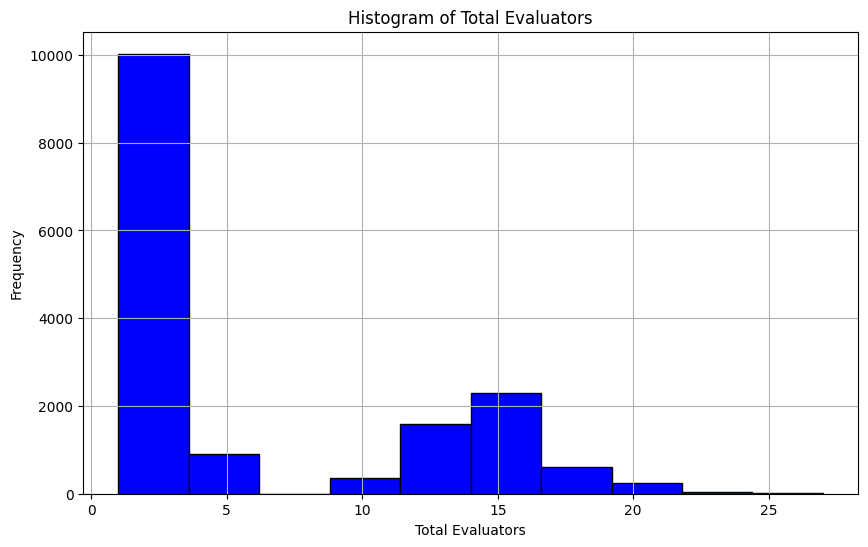

In [22]:
print("Pop 1: train unique eeg_id + votes shape:", train_pops[0].shape)
plt.figure(figsize=(10, 6))
plt.hist(train["total_evaluators"], bins=10, color="blue", edgecolor="black")
plt.title("Histogram of Total Evaluators")
plt.xlabel("Total Evaluators")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Deduplicate Train EEG Id

In [24]:
if CFG.visualize:
    train_dataset = EEGDataset(
        train_pops[0], batch_size=CFG.batch_size, eegs=all_eegs, mode="train"
    )
    train_loader = DataLoader(
        train_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    output = train_dataset[0]
    X, y = output["eeg"], output["labels"]
    print(f"X shape: {X.shape}, y shape: {y.shape}")

    iot = torch.randn(2, CFG.nsamples, CFG.in_channels)  # .cuda()
    model = EEGNet(
        kernels=CFG.kernels,
        in_channels=CFG.in_channels,
        fixed_kernel_size=CFG.fixed_kernel_size,
        num_classes=CFG.target_size,
        linear_layer_features=CFG.linear_layer_features,
    )
    output = model(iot)
    print(output.shape)

    for batch in train_loader:
        X = batch.pop("eeg")
        y = batch.pop("labels")
        for item in range(4):
            plt.figure(figsize=(20, 4))
            offset = 0
            for col in range(X.shape[-1]):
                if col != 0:
                    offset -= X[item, :, col].min()
                plt.plot(
                    range(CFG.nsamples),
                    X[item, :, col] + offset,
                    label=f"feature {col+1}",
                )
                offset += X[item, :, col].max()
            tt = f"{y[col][0]:0.1f}"
            for t in y[col][1:]:
                tt += f", {t:0.1f}"
            plt.title(f"EEG_Id = {eeg_ids[item]}\nTarget = {tt}", size=14)
            plt.legend()
            plt.show()
        break

    del iot, model
    gc.collect()

In [23]:
# %%time
if CFG.create_eegs:
    all_eegs = {}
    visualize = 1 if CFG.visualize else 0
    eeg_ids = train.eeg_id.unique()

    for i, eeg_id in tqdm(enumerate(eeg_ids)):

        eeg_path = CFG.path_train / f"{eeg_id}.parquet"

        data = eeg_from_parquet(eeg_path, display=i < visualize)
        all_eegs[eeg_id] = data

        if i == visualize:
            if CFG.create_eegs:
                print(
                    f"Processing {train['eeg_id'].nunique()} eeg parquets... ", end=""
                )
            else:
                print(f"Reading {len(eeg_ids)} eeg NumPys from disk.")
                break
    np.save("./eegs", all_eegs)

else:
    all_eegs = np.load(CFG.file_raw_eeg, allow_pickle=True).item()

# Train Stages

In [25]:
def get_score(preds, targets):
    oof = pd.DataFrame(preds.copy())
    oof["id"] = np.arange(len(oof))
    true = pd.DataFrame(targets.copy())
    true["id"] = np.arange(len(true))
    cv = kaggle_kl_div.score(solution=true, submission=oof, row_id_column_name="id")
    return cv


def get_result(result_df):
    gt = result_df[["eeg_id"] + CFG.target_cols]
    gt.sort_values(by="eeg_id", inplace=True)
    gt.reset_index(inplace=True, drop=True)
    preds = result_df[["eeg_id"] + CFG.pred_cols]
    preds.columns = ["eeg_id"] + CFG.target_cols
    preds.sort_values(by="eeg_id", inplace=True)
    preds.reset_index(inplace=True, drop=True)
    score_loss = get_score(gt[CFG.target_cols], preds[CFG.target_cols])
    LOGGER.info(f"Score with best loss weights: {score_loss}")

In [26]:
if __name__ == "__main__" and CFG.train_by_stages:
    seed_torch(seed=CFG.seed)

    prev_dir = ""
    for stage in range(len(CFG.total_evaluators)):
        pop_dir = f"{OUTPUT_DIR}pop_{stage+1}_weight_oof/"
        if not os.path.exists(pop_dir):
            os.makedirs(pop_dir)

        if stage not in CFG.train_stages:
            prev_dir = pop_dir
            continue

        oof_df = pd.DataFrame()
        scores = []
        for fold in CFG.train_folds:
            train_oof_df, score = train_loop(
                stage=stage + 1,
                epochs=CFG.epochs[stage],
                fold=fold,
                folds=train_pops[stage],
                directory=pop_dir,
                prev_dir=prev_dir,
                eggs=all_eegs,
            )

            oof_df = pd.concat([oof_df, train_oof_df])
            scores.append(score)

            LOGGER.info(f"========== stage: {stage+1} fold: {fold} result ==========")
            LOGGER.info(f"Score with best loss weights stage{stage+1}: {score:.4f}")

        LOGGER.info(f"==================== CV ====================")
        LOGGER.info(f"Score with best loss weights: {np.mean(scores):.4f}")

        oof_df.reset_index(drop=True, inplace=True)
        oof_df.to_csv(
            f"{pop_dir}{CFG.model_name}_oof_df_ver-{CFG.VERSION}_stage-{stage+1}.csv",
            index=False,
        )

        prev_dir = pop_dir

    if CFG.wandb:
        wandb.finish()

In [29]:
if __name__ == "__main__" and CFG.train_by_folds:
    seed_torch(seed=CFG.seed)

    stages_scores = {i: [] for i in CFG.train_stages}
    stages_oof_df = {i: pd.DataFrame() for i in CFG.train_stages}

    for fold in CFG.train_folds:

        prev_dir = ""
        for stage in range(len(CFG.total_evaluators)):

            pop_dir = f"{OUTPUT_DIR}pop_{stage+1}_weight_oof/"
            if not os.path.exists(pop_dir):
                os.makedirs(pop_dir)

            if stage not in CFG.train_stages:
                prev_dir = pop_dir
                continue

            train_oof_df, score = train_loop(
                stage=stage + 1,
                epochs=CFG.epochs[stage],
                fold=fold,
                folds=train_pops[stage],
                directory=pop_dir,
                prev_dir=prev_dir,
                eggs=all_eegs,
            )

            stages_oof_df[stage] = pd.concat([stages_oof_df[stage], train_oof_df])
            stages_scores[stage].append(score)

            prev_dir = pop_dir

            LOGGER.info(f"========== fold: {fold} stage: {stage+1} result ==========")
            LOGGER.info(f"Score with best loss weights stage{stage+1}: {score:.4f}")

    for stage, scores in stages_scores.items():
        LOGGER.info(f"============ CV score with best loss weights ============")
        LOGGER.info(f"Stage {stage}: {np.mean(scores):.4f}")

    for stage, oof_df in stages_oof_df.items():
        pop_dir = f"{OUTPUT_DIR}pop_{stage+1}_weight_oof/"
        oof_df.reset_index(drop=True, inplace=True)
        oof_df.to_csv(
            f"{pop_dir}{CFG.model_name}_oof_df_ver-{CFG.VERSION}_stage-{stage+1}.csv",
            index=False,
        )

    if CFG.wandb:
        wandb.finish()

========== stage: 1 fold: 0 training 134 / 17 ==========
Epoch 1 Avg Train Loss: 1.3906 Avg Valid Loss: 1.2827 / 
Epoch 1 Save Best Valid Loss: 1.2827
Epoch 2 Avg Train Loss: 1.2219 Avg Valid Loss: 1.1882 / 
Epoch 2 Save Best Valid Loss: 1.1882
Epoch 3 Avg Train Loss: 1.1319 Avg Valid Loss: 1.0155 / 
Epoch 3 Save Best Valid Loss: 1.0155
Epoch 4 Avg Train Loss: 1.0912 Avg Valid Loss: 0.9735 / 
Epoch 4 Save Best Valid Loss: 0.9735
Epoch 5 Avg Train Loss: 1.0469 Avg Valid Loss: 0.9406 / 
Epoch 5 Save Best Valid Loss: 0.9406
Epoch 6 Avg Train Loss: 1.0368 Avg Valid Loss: 0.8935 / 
Epoch 6 Save Best Valid Loss: 0.8935
Epoch 7 Avg Train Loss: 0.9895 Avg Valid Loss: 0.8895 / 
Epoch 7 Save Best Valid Loss: 0.8895
Epoch 8 Avg Train Loss: 0.9847 Avg Valid Loss: 0.8833 / 
Epoch 8 Save Best Valid Loss: 0.8833
Epoch 9 Avg Train Loss: 0.9719 Avg Valid Loss: 0.8543 / 
Epoch 9 Save Best Valid Loss: 0.8543
Epoch 10 Avg Train Loss: 0.9664 Avg Valid Loss: 0.8734 / 
Epoch 11 Avg Train Loss: 0.9476 Avg Val

Epoch 77 Avg Train Loss: 0.3827 Avg Valid Loss: 0.4638 / 
Epoch 78 Avg Train Loss: 0.3828 Avg Valid Loss: 0.4213 / 
Epoch 79 Avg Train Loss: 0.3814 Avg Valid Loss: 0.4574 / 
Epoch 80 Avg Train Loss: 0.3825 Avg Valid Loss: 0.4455 / 
Epoch 81 Avg Train Loss: 0.3853 Avg Valid Loss: 0.4305 / 
Epoch 82 Avg Train Loss: 0.3936 Avg Valid Loss: 0.4474 / 
Epoch 83 Avg Train Loss: 0.3899 Avg Valid Loss: 0.4315 / 
Epoch 84 Avg Train Loss: 0.3823 Avg Valid Loss: 0.4356 / 
Epoch 85 Avg Train Loss: 0.3861 Avg Valid Loss: 0.5299 / 
Epoch 86 Avg Train Loss: 0.3840 Avg Valid Loss: 0.4671 / 
Epoch 87 Avg Train Loss: 0.3819 Avg Valid Loss: 0.4675 / 
Epoch 88 Avg Train Loss: 0.3830 Avg Valid Loss: 0.4434 / 
Epoch 89 Avg Train Loss: 0.3837 Avg Valid Loss: 0.4849 / 
Epoch 90 Avg Train Loss: 0.3840 Avg Valid Loss: 0.4489 / 
Epoch 91 Avg Train Loss: 0.3808 Avg Valid Loss: 0.4384 / 
Epoch 92 Avg Train Loss: 0.3872 Avg Valid Loss: 0.4466 / 
Epoch 93 Avg Train Loss: 0.3819 Avg Valid Loss: 0.4659 / 
Epoch 94 Avg T

Epoch 52 Avg Train Loss: 0.3983 Avg Valid Loss: 0.3834 / 
Epoch 52 Save Best Valid Loss: 0.3834
Epoch 53 Avg Train Loss: 0.4081 Avg Valid Loss: 0.4044 / 
Epoch 54 Avg Train Loss: 0.4094 Avg Valid Loss: 0.4464 / 
Epoch 55 Avg Train Loss: 0.4041 Avg Valid Loss: 0.4059 / 
Epoch 56 Avg Train Loss: 0.4125 Avg Valid Loss: 0.4310 / 
Epoch 57 Avg Train Loss: 0.4102 Avg Valid Loss: 0.3943 / 
Epoch 58 Avg Train Loss: 0.4081 Avg Valid Loss: 0.4000 / 
Epoch 59 Avg Train Loss: 0.3979 Avg Valid Loss: 0.4122 / 
Epoch 60 Avg Train Loss: 0.4014 Avg Valid Loss: 0.4039 / 
Epoch 61 Avg Train Loss: 0.4034 Avg Valid Loss: 0.3978 / 
Epoch 62 Avg Train Loss: 0.3913 Avg Valid Loss: 0.4051 / 
Epoch 63 Avg Train Loss: 0.3972 Avg Valid Loss: 0.3975 / 
Epoch 64 Avg Train Loss: 0.3967 Avg Valid Loss: 0.4221 / 
Epoch 65 Avg Train Loss: 0.4035 Avg Valid Loss: 0.4116 / 
Epoch 66 Avg Train Loss: 0.4040 Avg Valid Loss: 0.4237 / 
Epoch 67 Avg Train Loss: 0.3928 Avg Valid Loss: 0.4368 / 
Epoch 68 Avg Train Loss: 0.3967 Av

Epoch 28 Avg Train Loss: 0.4201 Avg Valid Loss: 0.4479 / 
Epoch 29 Avg Train Loss: 0.4191 Avg Valid Loss: 0.4597 / 
Epoch 30 Avg Train Loss: 0.4228 Avg Valid Loss: 0.4526 / 
Epoch 31 Avg Train Loss: 0.4259 Avg Valid Loss: 0.4580 / 
Epoch 32 Avg Train Loss: 0.4214 Avg Valid Loss: 0.4335 / 
Epoch 33 Avg Train Loss: 0.4109 Avg Valid Loss: 0.4590 / 
Epoch 34 Avg Train Loss: 0.4197 Avg Valid Loss: 0.4582 / 
Epoch 35 Avg Train Loss: 0.4077 Avg Valid Loss: 0.4389 / 
Epoch 36 Avg Train Loss: 0.4173 Avg Valid Loss: 0.4342 / 
Epoch 37 Avg Train Loss: 0.4192 Avg Valid Loss: 0.5096 / 
Epoch 38 Avg Train Loss: 0.4187 Avg Valid Loss: 0.4447 / 
Epoch 39 Avg Train Loss: 0.4057 Avg Valid Loss: 0.4413 / 
Epoch 40 Avg Train Loss: 0.4186 Avg Valid Loss: 0.4458 / 
Epoch 41 Avg Train Loss: 0.4144 Avg Valid Loss: 0.4245 / 
Epoch 41 Save Best Valid Loss: 0.4245
Epoch 42 Avg Train Loss: 0.4062 Avg Valid Loss: 0.4438 / 
Epoch 43 Avg Train Loss: 0.4101 Avg Valid Loss: 0.4586 / 
Epoch 44 Avg Train Loss: 0.4110 Av

Epoch 3 Save Best Valid Loss: 0.4373
Epoch 4 Avg Train Loss: 0.4522 Avg Valid Loss: 0.4113 / 
Epoch 4 Save Best Valid Loss: 0.4113
Epoch 5 Avg Train Loss: 0.4476 Avg Valid Loss: 0.4368 / 
Epoch 6 Avg Train Loss: 0.4454 Avg Valid Loss: 0.4453 / 
Epoch 7 Avg Train Loss: 0.4397 Avg Valid Loss: 0.4275 / 
Epoch 8 Avg Train Loss: 0.4370 Avg Valid Loss: 0.4284 / 
Epoch 9 Avg Train Loss: 0.4341 Avg Valid Loss: 0.4415 / 
Epoch 10 Avg Train Loss: 0.4435 Avg Valid Loss: 0.4399 / 
Epoch 11 Avg Train Loss: 0.4335 Avg Valid Loss: 0.4163 / 
Epoch 12 Avg Train Loss: 0.4351 Avg Valid Loss: 0.4346 / 
Epoch 13 Avg Train Loss: 0.4281 Avg Valid Loss: 0.4379 / 
Epoch 14 Avg Train Loss: 0.4209 Avg Valid Loss: 0.4467 / 
Epoch 15 Avg Train Loss: 0.4299 Avg Valid Loss: 0.4425 / 
Epoch 16 Avg Train Loss: 0.4320 Avg Valid Loss: 0.4299 / 
Epoch 17 Avg Train Loss: 0.4249 Avg Valid Loss: 0.5099 / 
Epoch 18 Avg Train Loss: 0.4225 Avg Valid Loss: 0.4567 / 
Epoch 19 Avg Train Loss: 0.4233 Avg Valid Loss: 0.4336 / 
Epoc

Epoch 34 Avg Train Loss: 0.8543 Avg Valid Loss: 0.8943 / 
Epoch 35 Avg Train Loss: 0.8379 Avg Valid Loss: 0.8956 / 
Epoch 36 Avg Train Loss: 0.8257 Avg Valid Loss: 0.8944 / 
Epoch 37 Avg Train Loss: 0.8395 Avg Valid Loss: 0.9004 / 
Epoch 38 Avg Train Loss: 0.8357 Avg Valid Loss: 0.8912 / 
Epoch 39 Avg Train Loss: 0.8241 Avg Valid Loss: 0.9175 / 
Epoch 40 Avg Train Loss: 0.8229 Avg Valid Loss: 0.9161 / 
Epoch 41 Avg Train Loss: 0.8123 Avg Valid Loss: 0.8792 / 
Epoch 42 Avg Train Loss: 0.8242 Avg Valid Loss: 0.9056 / 
Epoch 43 Avg Train Loss: 0.8309 Avg Valid Loss: 0.9220 / 
Epoch 44 Avg Train Loss: 0.8041 Avg Valid Loss: 0.9657 / 
Epoch 45 Avg Train Loss: 0.8215 Avg Valid Loss: 0.9270 / 
Epoch 46 Avg Train Loss: 0.8153 Avg Valid Loss: 0.9187 / 
Epoch 47 Avg Train Loss: 0.8059 Avg Valid Loss: 0.8566 / 
Epoch 47 Save Best Valid Loss: 0.8566
Epoch 48 Avg Train Loss: 0.8040 Avg Valid Loss: 0.8789 / 
Epoch 49 Avg Train Loss: 0.8085 Avg Valid Loss: 0.8904 / 
Epoch 50 Avg Train Loss: 0.8270 Av